In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Commençons par charger et lire un exemple de fichier audio 

In [ ]:
!pip install librosa
import librosa
from librosa import display
data, sampling_rate = librosa.load('/content/drive/My Drive/Ravdess/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

Examinons ensuite un graphique d'onde de ce fichier audio en utilisant librosa.display.waveplot 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


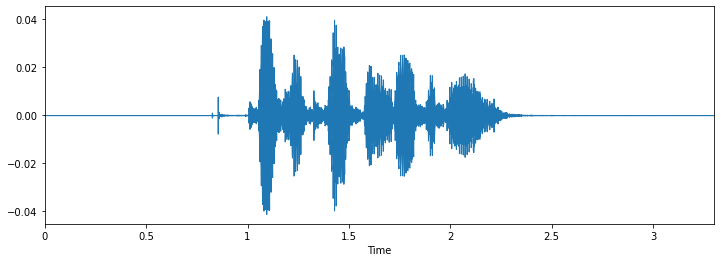

In [ ]:
% pylab inline
import os
import pandas as pd

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

What is audio sampling rate?
The sampling rate refers to the number of samples of audio recorded every second. It is measured in samples per second or Hertz (abbreviated as Hz or kHz, with one kHz being 1000 Hz). An audio sample is just a number representing the measured acoustic wave value at a specific point in time.

**Charger tout les fichier**

 **os.path.join**(path, *paths)

  Join one or more path components intelligently. The return value is the concatenation of path and any members of *paths with exactly one directory separator following each non-empty part except the last, meaning that the result will only end in a separator if the last part is empty. If a component is an absolute path, all previous components are thrown away and joining continues from the absolute path component.


 **numpy.mean**(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)

  Compute the arithmetic mean along the specified axis.

  Returns the average of the array elements. The average is taken over the flattened array by default, otherwise over the specified axis. float64 intermediate and return values are used for integer inputs.

In [ ]:
import time
path = '/content/drive/My Drive/Ravdess/'
lst = []

start_time = time.time()
for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 1636.514396905899 seconds ---


The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together

In [ ]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [ ]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2497, 40), (2497,))

In [ ]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/drive/My Drive/Ravdess_model'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [ ]:
# Loading saved models

X = joblib.load('/content/drive/My Drive/Ravdess_model/X.joblib')
y = joblib.load('/content/drive/My Drive/Ravdess_model/y.joblib')

**Decision Tree Classifier**

L’apprentissage par arbre de décision désigne une méthode basée sur l'utilisation d'un arbre de décision comme modèle prédictif. On l'utilise notamment en fouille de données et en apprentissage automatique.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**fit**(X, y, sample_weight=None, check_input=True,X_idx_sorted='deprecated')

Build a decision tree classifier from the training set (X, y).

**X**{array-like, sparse matrix} of shape (n_samples, n_features)
  The training input samples. Internally, it will be converted to dtype=np.float32 and if a sparse matrix is provided to a sparse csc_matrix.
  
**y** array-like of shape (n_samples,) or (n_samples, n_outputs)

  The target values (class labels) as integers or strings.



In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
predictions = dtree.predict(X_test)

emotions = { "neutral": "0", "calm": "1", "happy": "2", "sad": "3", "angry": "4", "fearful": "5", "disgust": "6", "surprised": "7" }

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.46      0.43      0.44        70
           1       0.53      0.58      0.56       115
           2       0.45      0.48      0.46       121
           3       0.40      0.44      0.42       118
           4       0.54      0.54      0.54       117
           5       0.43      0.43      0.43       134
           6       0.24      0.24      0.24        67
           7       0.38      0.27      0.31        83

    accuracy                           0.44       825
   macro avg       0.43      0.42      0.43       825
weighted avg       0.44      0.44      0.44       825



**Random Forest**

L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [ ]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [ ]:
predictions = rforest.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.44      0.61        70
           1       0.56      0.90      0.69       115
           2       0.58      0.58      0.58       121
           3       0.56      0.58      0.57       118
           4       0.73      0.85      0.78       117
           5       0.60      0.57      0.58       134
           6       0.35      0.28      0.31        67
           7       0.74      0.42      0.54        83

    accuracy                           0.61       825
   macro avg       0.64      0.58      0.58       825
weighted avg       0.63      0.61      0.60       825



**Neural network**

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape, x_testcnn.shape

((1672, 40, 1), (825, 40, 1))

Le modèle **séquentiel** est une pile linéaire de couches.

Vous pouvez créer un modèle séquentiel en passant au constructeur une liste d’instances de couches .
Vous pouvez également les ajouter à un modèle existant avec la méthode .add() :

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 128)           768       
_________________________________________________________________
activation (Activation)      (None, 40, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_1 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
105/105 [==============================] - 2s 10ms/step - loss: 7.3364 - accuracy: 0.1304 - val_loss: 2.7527 - val_accuracy: 0.1648
Epoch 2/1000
105/105 [==============================] - 1s 8ms/step - loss: 6.1661 - accuracy: 0.1334 - val_loss: 2.7340 - val_accuracy: 0.1503
Epoch 3/1000
105/105 [==============================] - 1s 9ms/step - loss: 5.4871 - accuracy: 0.1507 - val_loss: 2.6945 - val_accuracy: 0.2085
Epoch 4/1000
105/105 [==============================] - 1s 8ms/step - loss: 4.8244 - accuracy: 0.1717 - val_loss: 2.3599 - val_accuracy: 0.2242
Epoch 5/1000
105/105 [==============================] - 1s 8ms/step - loss: 4.2137 - accuracy: 0.1687 - val_loss: 2.0548 - val_accuracy: 0.2485
Epoch 6/1000
105/105 [==============================] - 1s 7ms/step - loss: 3.7572 - accuracy: 0.1699 - val_loss: 2.1557 - val_accuracy: 0.2242
Epoch 7/1000
105/105 [==============================] - 1s 7ms/step - loss: 3.3199 - accuracy: 0.1836 - val_loss: 2.1356 - val_accuracy

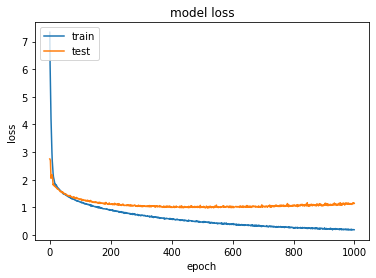

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

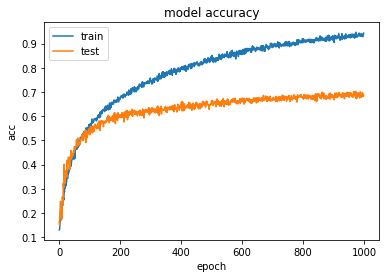

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
predictions = np.argmax(model.predict(x_testcnn),axis=1)

In [ ]:
predictions

array([2, 3, 3, 0, 2, 4, 3, 7, 1, 1, 5, 2, 4, 4, 0, 1, 6, 5, 6, 4, 3, 2,
       6, 4, 5, 7, 2, 5, 1, 5, 2, 5, 1, 5, 3, 2, 7, 5, 1, 2, 1, 3, 7, 4,
       4, 1, 3, 0, 1, 1, 1, 0, 3, 4, 0, 0, 2, 4, 1, 0, 2, 7, 4, 0, 5, 6,
       7, 0, 7, 3, 4, 4, 6, 3, 4, 7, 3, 3, 3, 6, 7, 1, 2, 3, 7, 5, 5, 5,
       5, 5, 4, 1, 3, 1, 1, 2, 5, 5, 6, 2, 2, 6, 4, 3, 0, 2, 2, 3, 5, 4,
       3, 1, 4, 0, 4, 3, 1, 3, 5, 4, 3, 2, 5, 5, 6, 0, 5, 7, 4, 5, 5, 3,
       4, 4, 3, 5, 1, 7, 4, 5, 5, 6, 7, 5, 3, 1, 1, 5, 4, 5, 5, 6, 4, 5,
       6, 5, 3, 2, 5, 6, 7, 1, 3, 1, 3, 4, 1, 7, 4, 1, 6, 7, 7, 3, 1, 0,
       0, 5, 5, 1, 3, 7, 7, 3, 1, 5, 7, 6, 1, 3, 2, 5, 5, 6, 4, 2, 4, 1,
       3, 1, 4, 7, 5, 6, 0, 7, 5, 7, 4, 5, 4, 1, 3, 7, 7, 5, 4, 1, 0, 2,
       6, 4, 1, 1, 1, 2, 4, 3, 1, 1, 7, 7, 6, 2, 5, 4, 2, 6, 5, 2, 1, 4,
       1, 1, 1, 5, 3, 5, 5, 5, 1, 6, 2, 1, 4, 2, 3, 4, 4, 5, 3, 1, 3, 5,
       1, 3, 0, 2, 2, 2, 3, 5, 0, 7, 2, 1, 1, 1, 2, 2, 1, 5, 4, 5, 5, 5,
       1, 2, 5, 5, 2, 1, 0, 4, 1, 2, 2, 4, 5, 4, 2,

In [ ]:
y_test

array([2, 3, 3, 0, 6, 7, 3, 7, 0, 4, 4, 2, 4, 4, 0, 1, 6, 5, 6, 4, 0, 2,
       6, 4, 5, 7, 2, 5, 3, 6, 2, 5, 3, 5, 3, 2, 7, 3, 1, 2, 1, 3, 3, 2,
       2, 3, 3, 0, 1, 1, 1, 0, 3, 4, 0, 0, 2, 4, 3, 0, 2, 7, 4, 0, 5, 6,
       7, 0, 7, 3, 5, 2, 6, 1, 4, 7, 5, 0, 3, 0, 7, 1, 2, 3, 7, 5, 6, 5,
       3, 5, 4, 1, 3, 1, 1, 2, 5, 6, 6, 4, 2, 6, 4, 3, 0, 6, 2, 5, 5, 4,
       3, 1, 4, 1, 4, 3, 3, 0, 0, 4, 3, 2, 5, 5, 6, 0, 5, 7, 4, 5, 5, 3,
       6, 4, 1, 5, 1, 7, 4, 2, 6, 3, 7, 5, 3, 1, 1, 5, 4, 5, 5, 5, 4, 1,
       7, 4, 3, 2, 5, 6, 7, 1, 7, 3, 1, 4, 1, 6, 4, 1, 6, 7, 2, 3, 1, 0,
       0, 3, 5, 1, 5, 7, 7, 3, 2, 2, 2, 6, 1, 3, 6, 5, 1, 6, 4, 2, 4, 3,
       3, 0, 2, 5, 3, 7, 0, 5, 5, 7, 4, 5, 4, 1, 5, 7, 7, 3, 4, 1, 0, 5,
       6, 4, 0, 1, 1, 2, 4, 0, 4, 1, 7, 7, 3, 7, 5, 4, 4, 6, 5, 7, 2, 4,
       1, 1, 1, 2, 3, 5, 2, 3, 1, 2, 2, 3, 6, 2, 3, 7, 4, 5, 3, 6, 4, 5,
       1, 3, 0, 2, 2, 2, 3, 5, 0, 7, 2, 1, 1, 3, 2, 2, 0, 5, 4, 3, 0, 7,
       4, 6, 5, 7, 2, 1, 0, 4, 1, 2, 2, 4, 5, 4, 2,

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

array([2, 3, 3, 0, 6, 7, 3, 7, 0, 4, 4, 2, 4, 4, 0, 1, 6, 5, 6, 4, 0, 2,
       6, 4, 5, 7, 2, 5, 3, 6, 2, 5, 3, 5, 3, 2, 7, 3, 1, 2, 1, 3, 3, 2,
       2, 3, 3, 0, 1, 1, 1, 0, 3, 4, 0, 0, 2, 4, 3, 0, 2, 7, 4, 0, 5, 6,
       7, 0, 7, 3, 5, 2, 6, 1, 4, 7, 5, 0, 3, 0, 7, 1, 2, 3, 7, 5, 6, 5,
       3, 5, 4, 1, 3, 1, 1, 2, 5, 6, 6, 4, 2, 6, 4, 3, 0, 6, 2, 5, 5, 4,
       3, 1, 4, 1, 4, 3, 3, 0, 0, 4, 3, 2, 5, 5, 6, 0, 5, 7, 4, 5, 5, 3,
       6, 4, 1, 5, 1, 7, 4, 2, 6, 3, 7, 5, 3, 1, 1, 5, 4, 5, 5, 5, 4, 1,
       7, 4, 3, 2, 5, 6, 7, 1, 7, 3, 1, 4, 1, 6, 4, 1, 6, 7, 2, 3, 1, 0,
       0, 3, 5, 1, 5, 7, 7, 3, 2, 2, 2, 6, 1, 3, 6, 5, 1, 6, 4, 2, 4, 3,
       3, 0, 2, 5, 3, 7, 0, 5, 5, 7, 4, 5, 4, 1, 5, 7, 7, 3, 4, 1, 0, 5,
       6, 4, 0, 1, 1, 2, 4, 0, 4, 1, 7, 7, 3, 7, 5, 4, 4, 6, 5, 7, 2, 4,
       1, 1, 1, 2, 3, 5, 2, 3, 1, 2, 2, 3, 6, 2, 3, 7, 4, 5, 3, 6, 4, 5,
       1, 3, 0, 2, 2, 2, 3, 5, 0, 7, 2, 1, 1, 3, 2, 2, 0, 5, 4, 3, 0, 7,
       4, 6, 5, 7, 2, 1, 0, 4, 1, 2, 2, 4, 5, 4, 2,

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.63      0.70        70
           1       0.72      0.88      0.79       115
           2       0.69      0.69      0.69       121
           3       0.63      0.56      0.59       118
           4       0.84      0.79      0.81       117
           5       0.60      0.75      0.66       134
           6       0.60      0.52      0.56        67
           7       0.66      0.54      0.60        83

    accuracy                           0.69       825
   macro avg       0.69      0.67      0.68       825
weighted avg       0.69      0.69      0.68       825



In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[ 44   8   0   9   0   4   2   3]
 [  2 101   5   4   0   2   0   1]
 [  1   6  84   2   8  12   3   5]
 [  2  17   1  66   0  24   5   3]
 [  0   3   7   2  92   8   4   1]
 [  2   0   7  14   3 100   2   6]
 [  0   3   9   2   5   9  35   4]
 [  5   2   8   5   2   9   7  45]]


**Enregistrer le model**

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/content/drive/My Drive/Ravdess_model'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Ravdess_model/Emotion_Voice_Detection_Model.h5 


In [ ]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Ravdess_model/Emotion_Voice_Detection_Model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 128)           768       
_________________________________________________________________
activation (Activation)      (None, 40, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_1 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0

In [ ]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

26/26 [==============================] - 0s 3ms/step - loss: 1.1446 - accuracy: 0.6873
Restored model, accuracy: 68.73%
